In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [2]:
import re
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras import backend as K

K.set_image_data_format('channels_last')

In [3]:
print(os.listdir("../input/ultrasound-nerve-segmentation"))

['train_masks.csv', 'sample_submission.csv', 'test', 'train']


In [4]:
path = "../input/ultrasound-nerve-segmentation/train/"
file_list = os.listdir(path)
file_list[:20]

['35_63_mask.tif',
 '34_68_mask.tif',
 '22_46.tif',
 '26_80_mask.tif',
 '34_6_mask.tif',
 '13_43.tif',
 '22_34_mask.tif',
 '25_102_mask.tif',
 '13_110_mask.tif',
 '23_60.tif',
 '43_79_mask.tif',
 '29_114_mask.tif',
 '5_29_mask.tif',
 '26_60.tif',
 '44_42.tif',
 '46_66_mask.tif',
 '43_53_mask.tif',
 '7_74.tif',
 '32_114.tif',
 '27_103.tif']

# Sort the file list in ascending order and seperate it into images and masks

In [5]:
reg = re.compile("[0-9]+")

temp1 = list(map(lambda x: reg.match(x).group(), file_list)) 
temp1 = list(map(int, temp1))

temp2 = list(map(lambda x: reg.match(x.split("_")[1]).group(), file_list))
temp2 = list(map(int, temp2))

file_list = [x for _,_,x in sorted(zip(temp1, temp2, file_list))]
file_list[:20]

['1_1.tif',
 '1_1_mask.tif',
 '1_2.tif',
 '1_2_mask.tif',
 '1_3.tif',
 '1_3_mask.tif',
 '1_4.tif',
 '1_4_mask.tif',
 '1_5.tif',
 '1_5_mask.tif',
 '1_6.tif',
 '1_6_mask.tif',
 '1_7.tif',
 '1_7_mask.tif',
 '1_8.tif',
 '1_8_mask.tif',
 '1_9.tif',
 '1_9_mask.tif',
 '1_10.tif',
 '1_10_mask.tif']

In [6]:
train_image = []

train_mask = []

for idx, item in enumerate(file_list):
    if idx % 2 == 0:
        train_image.append(item)
    else:
        train_mask.append(item)
        
print(train_image[:10],"\n" ,train_mask[:10])

['1_1.tif', '1_2.tif', '1_3.tif', '1_4.tif', '1_5.tif', '1_6.tif', '1_7.tif', '1_8.tif', '1_9.tif', '1_10.tif'] 
 ['1_1_mask.tif', '1_2_mask.tif', '1_3_mask.tif', '1_4_mask.tif', '1_5_mask.tif', '1_6_mask.tif', '1_7_mask.tif', '1_8_mask.tif', '1_9_mask.tif', '1_10_mask.tif']


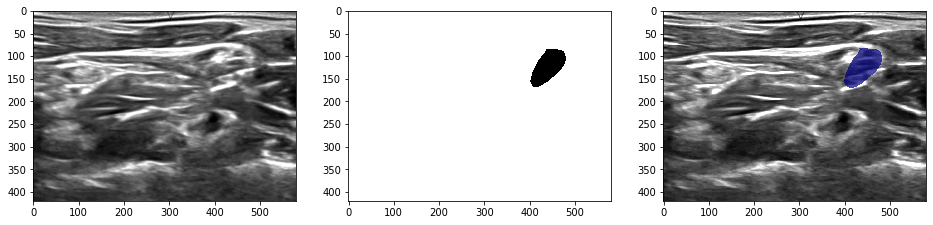

In [7]:
# Display the first image and mask of the first subject.
image1 = np.array(Image.open(path+"1_1.tif"))
image1_mask = np.array(Image.open(path+"1_1_mask.tif"))
image1_mask = np.ma.masked_where(image1_mask == 0, image1_mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(image1, cmap = 'gray')

ax[1].imshow(image1_mask, cmap = 'gray')

ax[2].imshow(image1, cmap = 'gray', interpolation = 'none')
ax[2].imshow(image1_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

In [8]:
## Storing data
X = []

y = []

for image, mask in zip(train_image, train_mask):
    
    X.append(np.array(Image.open(path+image)))
    
    y.append(np.array(Image.open(path+mask)))

In [9]:
X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)

X_shape :  (5635, 420, 580)
y_shape :  (5635, 420, 580)


In [10]:
mask_df = pd.read_csv("../input/ultrasound-nerve-segmentation/train_masks.csv")
mask_df.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [11]:
width = 580
height = 420

temp = mask_df["pixels"][0]
temp = temp.split(" ")

In [12]:
mask1 = np.zeros(height * width)
for i, num in enumerate(temp):
    if i % 2 == 0:
        run = int(num) -1             # very first pixel is 1, not 0
        length = int(temp[i+1])
        mask1[run:run+length] = 255 

#Since pixels are numbered from top to bottom, then left to right, we are careful to change the shape
mask1 = mask1.reshape((width, height))
mask1 = mask1.T

In [13]:
(mask1 != y[0]).sum()

0

In [14]:
# RLE : run-length-encoding
def RLE_to_image(rle):
    '''
    rle : array in mask_df["pixels"]
    '''
    width, height = 580, 420
    
    if rle == 0:
        return np.zeros((height,width))
    
    else:
        rle = rle.split(" ")
        mask = np.zeros(width * height)
        for i, num in enumerate(rle):
            if i % 2 == 0:
                run = int(num) - 1
                length = int(rle[i+1])
                mask[run:run+length] = 255

        mask = mask.reshape((width, height))
        mask = mask.T 

        return mask

In [15]:
print("The number of train data : ", X.shape[0])

The number of train data :  5635


In [16]:
mask_df.head()
subject_df = mask_df[['subject', 'img']].groupby(by = 'subject').agg('count').reset_index()
subject_df.columns = ['subject', 'N_of_img']
subject_df.sample(10)

,subject,N_of_img
29,30,120
44,45,120
32,33,120
25,26,120
0,1,120
15,16,120
40,41,120
16,17,119
8,9,120
17,18,120


In [17]:
pd.value_counts(subject_df['N_of_img']).reset_index()

,index,N_of_img
0,120,42
1,119,5


In [18]:
print(os.listdir("../input/ultrasound-nerve-segmentation/test")[0:15])

['1259.tif', '659.tif', '4794.tif', '274.tif', '315.tif', '919.tif', '3360.tif', '2037.tif', '1819.tif', '3660.tif', '1938.tif', '948.tif', '4303.tif', '5067.tif', '4296.tif']


In [19]:
from keras.models import Model, Input, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [20]:
# Randomly choose the indices of data used to train our model.
indices = np.random.choice(range(len(train_image)), replace = False ,size = 100)
train_image_sample = np.array(train_image)[indices]
train_mask_sample = np.array(train_mask)[indices]

In [21]:
# Build the dataset.
IMG_HEIGHT = 96
IMG_WIDTH = 96

X = np.empty(shape = (len(indices), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
y = np.empty(shape = (len(indices), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')

for i, (image_path, mask_path) in enumerate(zip(train_image_sample, train_mask_sample)):
    image = cv2.imread("../input/ultrasound-nerve-segmentation/train/" + image_path, 0)
    mask = cv2.imread("../input/ultrasound-nerve-segmentation/train/" + mask_path, 0)
    
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    
    X[i] = image
    y[i] = mask

X = X[:,:,:,np.newaxis] / 255
y = y[:,:,:,np.newaxis] / 255
print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (100, 96, 96, 1)
y shape :  (100, 96, 96, 1)


In [22]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [23]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr = 1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [24]:
results = model.fit(X, y, validation_split=0.1, batch_size=4, epochs=20)

Epoch 1/20
23/23 [==============================] - 9s 131ms/step - loss: -0.0282 - dice_coef: 0.0282 - val_loss: -0.0120 - val_dice_coef: 0.0100
Epoch 2/20
23/23 [==============================] - 2s 74ms/step - loss: -0.0266 - dice_coef: 0.0266 - val_loss: -0.0120 - val_dice_coef: 0.0100
Epoch 3/20
23/23 [==============================] - 2s 75ms/step - loss: -0.0325 - dice_coef: 0.0325 - val_loss: -0.0120 - val_dice_coef: 0.0100
Epoch 4/20
23/23 [==============================] - 2s 75ms/step - loss: -0.0271 - dice_coef: 0.0271 - val_loss: -0.0120 - val_dice_coef: 0.0100
Epoch 5/20
23/23 [==============================] - 2s 74ms/step - loss: -0.0249 - dice_coef: 0.0249 - val_loss: -0.0120 - val_dice_coef: 0.0101
Epoch 6/20
23/23 [==============================] - 2s 75ms/step - loss: -0.0229 - dice_coef: 0.0228 - val_loss: -0.0121 - val_dice_coef: 0.0101
Epoch 7/20
23/23 [==============================] - 2s 74ms/step - loss: -0.0249 - dice_coef: 0.0249 - val_loss: -0.0121 - val_di

In [25]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = cv2.imread("../input/ultrasound-nerve-segmentation/train/" + X_list[i], 0)
            mask = cv2.imread("../input/ultrasound-nerve-segmentation/train/" + y_list[i], 0)
    
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X[:,:,:,np.newaxis] / 255
        y = y[:,:,:,np.newaxis] / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y    

In [26]:
X_train, X_val, y_train, y_val = train_test_split(train_image, train_mask, test_size = 0.2, random_state = 42)

epochs = 20
batch_size = 8
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = Generator(X_train, y_train, batch_size = batch_size)
val_gen = Generator(X_val, y_val, batch_size = batch_size)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(lr = 1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [27]:
history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs,
                             validation_data = val_gen, validation_steps = validation_steps)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
563/563 [==============================] - 84s 145ms/step - loss: -0.1606 - dice_coef: 0.1606 - val_loss: -0.2574 - val_dice_coef: 0.2574
Epoch 2/20
563/563 [==============================] - 81s 145ms/step - loss: -0.1784 - dice_coef: 0.1784 - val_loss: -0.0014 - val_dice_coef: 0.0014
Epoch 3/20
563/563 [==============================] - 82s 145ms/step - loss: -0.0098 - dice_coef: 0.0098 - val_loss: -0.0014 - val_dice_coef: 0.0014
Epoch 4/20
563/563 [==============================] - 82s 145ms/step - loss: -0.0098 - dice_coef: 0.0098 - val_loss: -0.0014 - val_dice_coef: 0.0014
Epoch 5/20
563/563 [==============================] - 81s 144ms/step - loss: -0.0098 - dice_coef: 0.0098 - val_loss: -0.0014 - val_dice_coef: 0.0014
Epoch 6/20
563/563 [==============================] - 82s 145ms/step - loss: -0.0098 - dice_coef: 0.0098 - val_loss: -0.0014 - val_dice_coef: 0.0014
Epoch 7/20
563/563 [==============================] - 81s 145ms/step - loss: -0.0098 - dice_coef: 0.0098 -

In [28]:
sub = pd.read_csv("../input/ultrasound-nerve-segmentation/sample_submission.csv")
test_list = os.listdir("../input/ultrasound-nerve-segmentation/test")

print("The number of test data : ", len(test_list))

# Sort the test set in ascending order.
reg = re.compile("[0-9]+")

temp1 = list(map(lambda x: reg.match(x).group(), test_list)) 
temp1 = list(map(int, temp1))

test_list = [x for _,x in sorted(zip(temp1, test_list))]

test_list[:15]

The number of test data :  5508


['1.tif',
 '2.tif',
 '3.tif',
 '4.tif',
 '5.tif',
 '6.tif',
 '7.tif',
 '8.tif',
 '9.tif',
 '10.tif',
 '11.tif',
 '12.tif',
 '13.tif',
 '14.tif',
 '15.tif']

In [29]:
X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
for i, item in enumerate(test_list):
    image = cv2.imread("../input/ultrasound-nerve-segmentation/test/" + item, 0)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    X_test[i] = image
X_test = X_test[:,:,:,np.newaxis] / 255

y_pred = model.predict(X_test)

In [30]:
def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])
rles = []
for i in range(X_test.shape[0]):
    img = y_pred[i, :, :, 0]
    img = img > 0.5
    img = resize(img, (420, 580), preserve_range=True)
    rle = run_length_enc(img)
    rles.append(rle)
    if i % 100 == 0:
            print('{}/{}'.format(i, X_test.shape[0]), end = "\r")

In [31]:
sub['pixels'] = rles
sub.to_csv("submission.csv", index = False)